# NLP 
## stock_market_sa

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import warnings
warnings.simplefilter(action='ignore')
import spacy
import requests
from bs4 import BeautifulSoup
import re

In [2]:
def company_news(company):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36(KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
    url = 'https://finviz.com/quote.ashx?t={}&p=d'.format(company)
    request = requests.get(url, headers={'User-Agent':user_agent})
    parser = BeautifulSoup(request.text, 'html.parser')
    news_html = parser.find_all('a',{'class':'tab-link-news'})
    regex = "target=\"_blank\">(.*?)<\/a>"
    regex_news = [re.findall(regex, str(sentence)) for sentence in news_html]
    # Creating the Lists to Append
    news_list = []
    for x in regex_news:
        news_list.append(x[0])
    # Creating the Dictionary
    news_dict = {}
    news_dict['Company'] = company
    news_dict['News'] = news_list
    # Converting into a Dataframe
    final_df = pd.DataFrame(news_dict)
    return final_df

## Creating a Dataframe with 5 companies from different sectors:

	• Amazon –> AMZN
    • Netflix –> NFLX
	• Intel Corporation –> INTC
	• Tesla –> TSLA
	• Eni –> E
### Creating a unique dataframe for all of them.

In [3]:
companies_df = pd.DataFrame()
tickers = ['AMZN', 'NFLX', 'INTC', 'TSLA', 'E']
for c in tickers:
    new_df = company_news(c)
    companies_df = pd.concat([companies_df, new_df])

In [4]:
companies_df

,Company,News
0,AMZN,Whole Foods closes San Francisco flagship stor...
1,AMZN,Certain Amazon returns at UPS stores come with...
2,AMZN,"Walmart Has a Bold, Free Offer For Its Customers"
3,AMZN,Amazon offices won't be ready for May 1 employ...
4,AMZN,"Amazons Twitch Safety, AI Ethics Job Cuts Rais..."
...,...,...
95,E,"Zacks Industry Outlook Highlights Exxon Mobil,..."
96,E,5 Energy Stocks From the Promising Integrated ...
97,E,Eni SpA (E) Gains As Market Dips: What You Sho...
98,E,Here is Why Growth Investors Should Buy Eni Sp...


In [5]:
companies_df.Company.value_counts()

AMZN    100
NFLX    100
INTC    100
TSLA    100
E       100
Name: Company, dtype: int64

### Resetting the Index

In [6]:
companies_df = companies_df.reset_index().drop(columns='index')
companies_df

,Company,News
0,AMZN,Whole Foods closes San Francisco flagship stor...
1,AMZN,Certain Amazon returns at UPS stores come with...
2,AMZN,"Walmart Has a Bold, Free Offer For Its Customers"
3,AMZN,Amazon offices won't be ready for May 1 employ...
4,AMZN,"Amazons Twitch Safety, AI Ethics Job Cuts Rais..."
...,...,...
495,E,"Zacks Industry Outlook Highlights Exxon Mobil,..."
496,E,5 Energy Stocks From the Promising Integrated ...
497,E,Eni SpA (E) Gains As Market Dips: What You Sho...
498,E,Here is Why Growth Investors Should Buy Eni Sp...


## Applying Sentiment Analysis 

In [7]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [8]:
pre_trained_model = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model)
model = AutoModelForSequenceClassification.from_pretrained(pre_trained_model)

In [9]:
def roberta_scores(row):
    try:
        # Tokenizing the text and putting it into the model
        tokenized_text = tokenizer(row['News'], return_tensors='pt')
        model_output = model(**tokenized_text)
        # Taking only the scores from the Tensors and putting them in a NumPyarray
        scores = model_output[0][0].detach().numpy()
        # Applying the Softmax function to obtain the probability distribution
        scores = softmax(scores)
        # Storing the results into a dictionary
        scores_dict = {
            'negative_score':scores[0],
            'neutral_score':scores[1],
            'positive_score':scores[2]
        }
        return scores_dict
    except :
        return 'Text too big'


### Applying the function to the “News” variable of the “companies_df”.

In [10]:
companies_df['Sentiment_Scores'] = companies_df.apply(roberta_scores, axis=1)

In [11]:
companies_df

,Company,News,Sentiment_Scores
0,AMZN,Whole Foods closes San Francisco flagship stor...,"{'negative_score': 0.34999755, 'neutral_score'..."
1,AMZN,Certain Amazon returns at UPS stores come with...,"{'negative_score': 0.17770323, 'neutral_score'..."
2,AMZN,"Walmart Has a Bold, Free Offer For Its Customers","{'negative_score': 0.002664405, 'neutral_score..."
3,AMZN,Amazon offices won't be ready for May 1 employ...,"{'negative_score': 0.6702384, 'neutral_score':..."
4,AMZN,"Amazons Twitch Safety, AI Ethics Job Cuts Rais...","{'negative_score': 0.48447764, 'neutral_score'..."
...,...,...,...
495,E,"Zacks Industry Outlook Highlights Exxon Mobil,...","{'negative_score': 0.010740114, 'neutral_score..."
496,E,5 Energy Stocks From the Promising Integrated ...,"{'negative_score': 0.031083561, 'neutral_score..."
497,E,Eni SpA (E) Gains As Market Dips: What You Sho...,"{'negative_score': 0.037193004, 'neutral_score..."
498,E,Here is Why Growth Investors Should Buy Eni Sp...,"{'negative_score': 0.01214447, 'neutral_score'..."


#### Creating a columns for each score.

In [12]:
sentiment_dict = {}
for index, news in zip(companies_df.index, companies_df.Sentiment_Scores):
    sentiment_dict[index] = news
sentiment_dict


{0: {'negative_score': 0.34999755,
  'neutral_score': 0.6260712,
  'positive_score': 0.02393122},
 1: {'negative_score': 0.17770323,
  'neutral_score': 0.7696036,
  'positive_score': 0.05269314},
 2: {'negative_score': 0.002664405,
  'neutral_score': 0.18806538,
  'positive_score': 0.80927026},
 3: {'negative_score': 0.6702384,
  'neutral_score': 0.3087248,
  'positive_score': 0.021036845},
 4: {'negative_score': 0.48447764,
  'neutral_score': 0.484438,
  'positive_score': 0.03108441},
 5: {'negative_score': 0.44105196,
  'neutral_score': 0.49163824,
  'positive_score': 0.06730983},
 6: {'negative_score': 0.006735036,
  'neutral_score': 0.57475054,
  'positive_score': 0.41851446},
 7: {'negative_score': 0.48176995,
  'neutral_score': 0.49877712,
  'positive_score': 0.019452976},
 8: {'negative_score': 0.66182995,
  'neutral_score': 0.3136446,
  'positive_score': 0.024525465},
 9: {'negative_score': 0.0015271676,
  'neutral_score': 0.033539955,
  'positive_score': 0.96493286},
 10: {'ne

In [13]:
pd.DataFrame(sentiment_dict)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
negative_score,0.349998,0.177703,0.002664,0.670238,0.484478,0.441052,0.006735,0.481770,0.661830,0.001527,...,0.018928,0.189576,0.002145,0.175541,0.303826,0.010740,0.031084,0.037193,0.012144,0.421548
neutral_score,0.626071,0.769604,0.188065,0.308725,0.484438,0.491638,0.574751,0.498777,0.313645,0.033540,...,0.946838,0.788602,0.147636,0.774342,0.661145,0.806292,0.866747,0.873099,0.613073,0.551563
positive_score,0.023931,0.052693,0.809270,0.021037,0.031084,0.067310,0.418514,0.019453,0.024525,0.964933,...,0.034234,0.021821,0.850219,0.050117,0.035029,0.182968,0.102169,0.089708,0.374783,0.026889


In [15]:
sentiment_df = pd.DataFrame(sentiment_dict).T
sentiment_df


,negative_score,neutral_score,positive_score
0,0.349998,0.626071,0.023931
1,0.177703,0.769604,0.052693
2,0.002664,0.188065,0.809270
3,0.670238,0.308725,0.021037
4,0.484478,0.484438,0.031084
...,...,...,...
495,0.010740,0.806292,0.182968
496,0.031084,0.866747,0.102169
497,0.037193,0.873099,0.089708
498,0.012144,0.613073,0.374783


In [16]:
final_df = companies_df.merge(sentiment_df, left_index=True, right_index=True)
final_df

,Company,News,Sentiment_Scores,negative_score,neutral_score,positive_score
0,AMZN,Whole Foods closes San Francisco flagship stor...,"{'negative_score': 0.34999755, 'neutral_score'...",0.349998,0.626071,0.023931
1,AMZN,Certain Amazon returns at UPS stores come with...,"{'negative_score': 0.17770323, 'neutral_score'...",0.177703,0.769604,0.052693
2,AMZN,"Walmart Has a Bold, Free Offer For Its Customers","{'negative_score': 0.002664405, 'neutral_score...",0.002664,0.188065,0.809270
3,AMZN,Amazon offices won't be ready for May 1 employ...,"{'negative_score': 0.6702384, 'neutral_score':...",0.670238,0.308725,0.021037
4,AMZN,"Amazons Twitch Safety, AI Ethics Job Cuts Rais...","{'negative_score': 0.48447764, 'neutral_score'...",0.484478,0.484438,0.031084
...,...,...,...,...,...,...
495,E,"Zacks Industry Outlook Highlights Exxon Mobil,...","{'negative_score': 0.010740114, 'neutral_score...",0.010740,0.806292,0.182968
496,E,5 Energy Stocks From the Promising Integrated ...,"{'negative_score': 0.031083561, 'neutral_score...",0.031084,0.866747,0.102169
497,E,Eni SpA (E) Gains As Market Dips: What You Sho...,"{'negative_score': 0.037193004, 'neutral_score...",0.037193,0.873099,0.089708
498,E,Here is Why Growth Investors Should Buy Eni Sp...,"{'negative_score': 0.01214447, 'neutral_score'...",0.012144,0.613073,0.374783


In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           500 non-null    object 
 1   News              500 non-null    object 
 2   Sentiment_Scores  500 non-null    object 
 3   negative_score    500 non-null    float32
 4   neutral_score     500 non-null    float32
 5   positive_score    500 non-null    float32
dtypes: float32(3), object(3)
memory usage: 17.7+ KB


In [18]:
final_df.groupby('Company')[['negative_score', 'neutral_score','positive_score']].mean()

,negative_score,neutral_score,positive_score
Company,,,
AMZN,0.171742,0.545859,0.282399
E,0.099289,0.687596,0.213116
INTC,0.127091,0.604233,0.268676
NFLX,0.105704,0.614627,0.279669
TSLA,0.184530,0.576729,0.238741


#### Checking the different scores’distirbution.

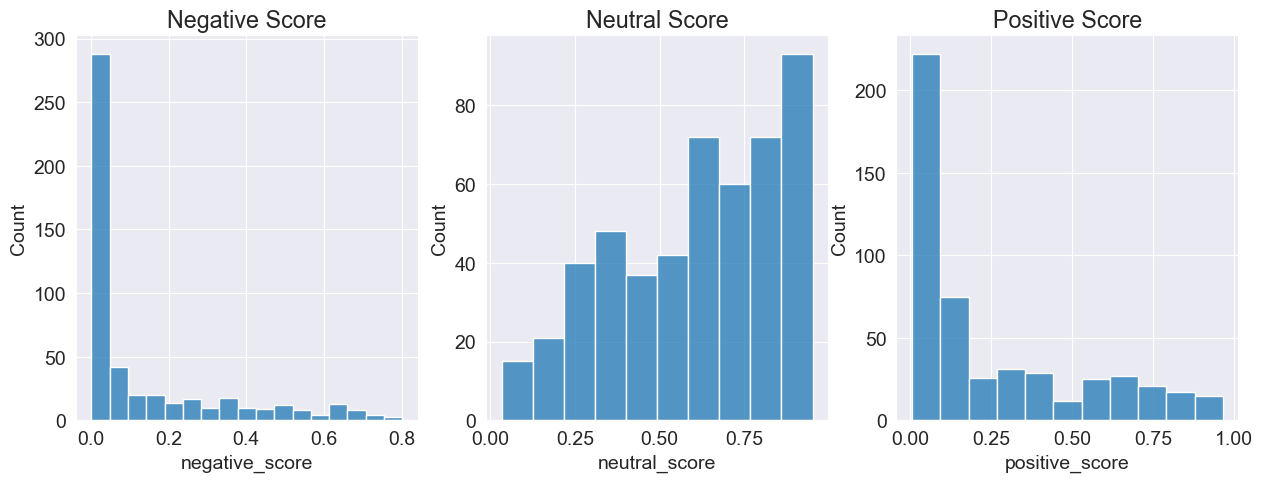

In [19]:
fig, ax = plt.subplots(1,3)
ax[0].set_title('Negative Score')
sns.histplot(data=final_df, x='negative_score', ax=ax[0])
ax[1].set_title('Neutral Score')
sns.histplot(data=final_df, x='neutral_score', ax=ax[1])
ax[2].set_title('Positive Score')
sns.histplot(data=final_df, x='positive_score', ax=ax[2]);

# conclusion 
	As a preliminary analysis, from my point of view, the most difficult part was the webscraping phase.
	Many sites have a really complex structure and it is quite difficult to inspect them well.
	Further improvements can be done in the future by including people’s opinions, for example by
	including tweets.